In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA

# ACE KRX 금현물 ETF 데이터 수집

- ACE KRX 금현물 ETF?
한국투자신탁운용이 2021년 12월에 상장한 국내 최초의 금 현물 ETF
한국거래소의 KRX 금현물 지수를 기초지수로 추종 (국제 금시세에 달러당 원화 가치 반영)

- 'ACE KRX금현물'은 연초부터 지금까지 수익률 38.04%를 기록 (11월 08일 기준)
- 글로벌 경제의 불확실성 요인 중 하나인 미대선 종료로 금값 하락
- 하지만 트럼프 당선은 중장기적으로 글로벌 경제 불확실성이 확대될 것으로 예상

- 따라서 포트폴리오 위험 분산을 위해 안전자산인 금 관련 etf 구매 예정
- ISA 계좌로 투자할 수 있는 유일한 금 투자 ETF인 ACE KRX 금현물 ETF 매수 고려

- 1년 이상 보유 시 수익률은 어떻게 될 지 예측을 통해 효율적인 매수 전략을 세우려함

<class 'pandas.core.frame.DataFrame'>
Index: 693 entries, 489 to 491
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              693 non-null    datetime64[ns]
 1   etf_Volume        693 non-null    int64         
 2   etf_Daily_Return  693 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 21.7 KB


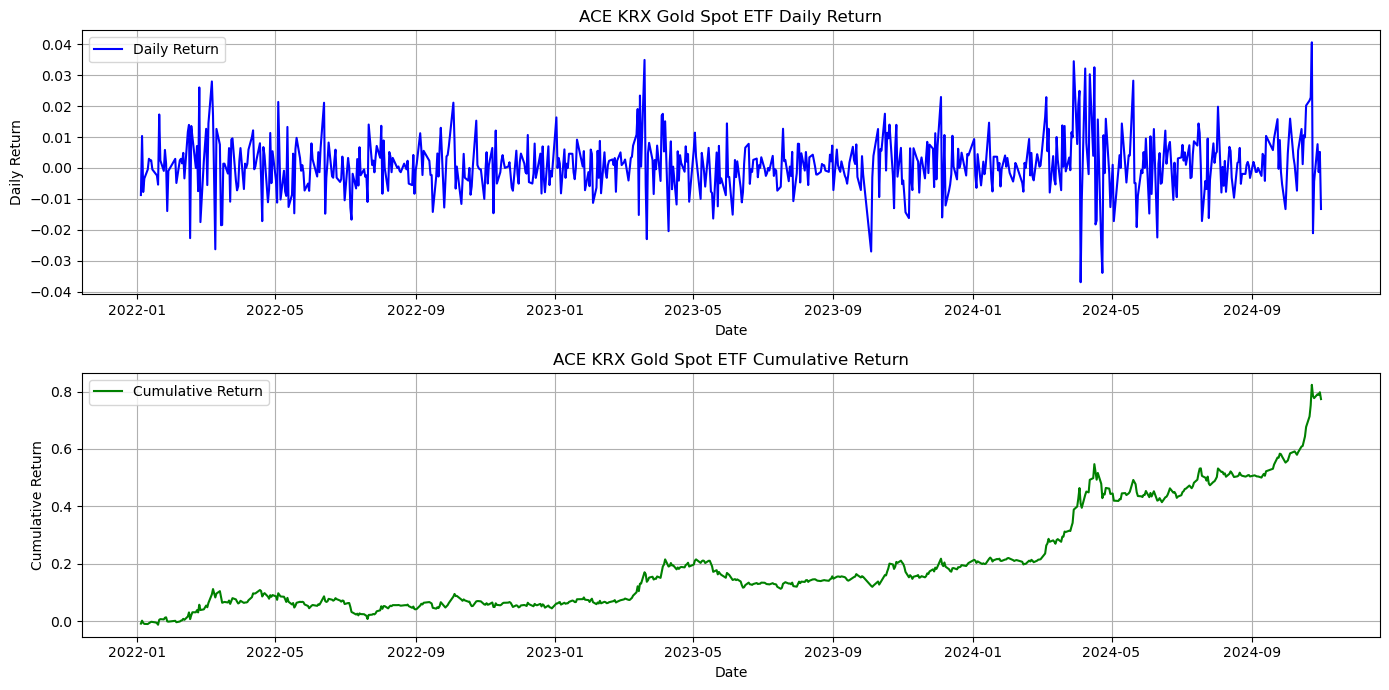

In [30]:
def load_data(file_2023, file_2024):
    try:
        etf_data_2023 = pd.read_csv(file_2023, encoding='cp949')
        etf_data_2024 = pd.read_csv(file_2024, encoding='cp949')
    except FileNotFoundError as e:
        print(f"Error: {e}")
        exit()
    return etf_data_2023, etf_data_2024

def preprocess_data(etf_data_2023, etf_data_2024):
    etf_data_2023['Date'] = pd.to_datetime(etf_data_2023['일자'])
    etf_data_2024['Date'] = pd.to_datetime(etf_data_2024['일자'])
    
    combined_data = pd.concat([etf_data_2023, etf_data_2024], ignore_index=True)
    combined_data.sort_values(by='Date', inplace=True)

    combined_data['Daily_Return'] = combined_data['종가'].pct_change()
    combined_data.dropna(subset=['Daily_Return'], inplace=True) 
    combined_data['Cumulative_Return'] = (1 + combined_data['Daily_Return']).cumprod() - 1

    return combined_data

def create_dataframe(combined_data):
    df = combined_data[['Date', '거래량', 'Daily_Return']].copy()  
    df.columns = ['Date', 'etf_Volume', 'etf_Daily_Return'] 
    df.info() 
    return df

def visualize_data(combined_data):
    plt.figure(figsize=(14, 7))

    plt.subplot(2, 1, 1)  
    plt.plot(combined_data['Date'], combined_data['Daily_Return'], label='Daily Return', color='blue')
    plt.title('ACE KRX Gold Spot ETF Daily Return')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.grid()
    plt.legend()

    plt.subplot(2, 1, 2)  
    plt.plot(combined_data['Date'], combined_data['Cumulative_Return'], label='Cumulative Return', color='green')
    plt.title('ACE KRX Gold Spot ETF Cumulative Return')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

# Main execution
file_2023 = 'ACE_KRX_Gold_Spot_ETF_2023.csv'
file_2024 = 'ACE_KRX_Gold_Spot_ETF_2024.csv'

etf_data_2023, etf_data_2024 = load_data(file_2023, file_2024)
combined_data = preprocess_data(etf_data_2023, etf_data_2024)
df = create_dataframe(combined_data)  
visualize_data(combined_data)


# XAU/USD 데이터 수집
금 현물가격 (미국 달러 기준)

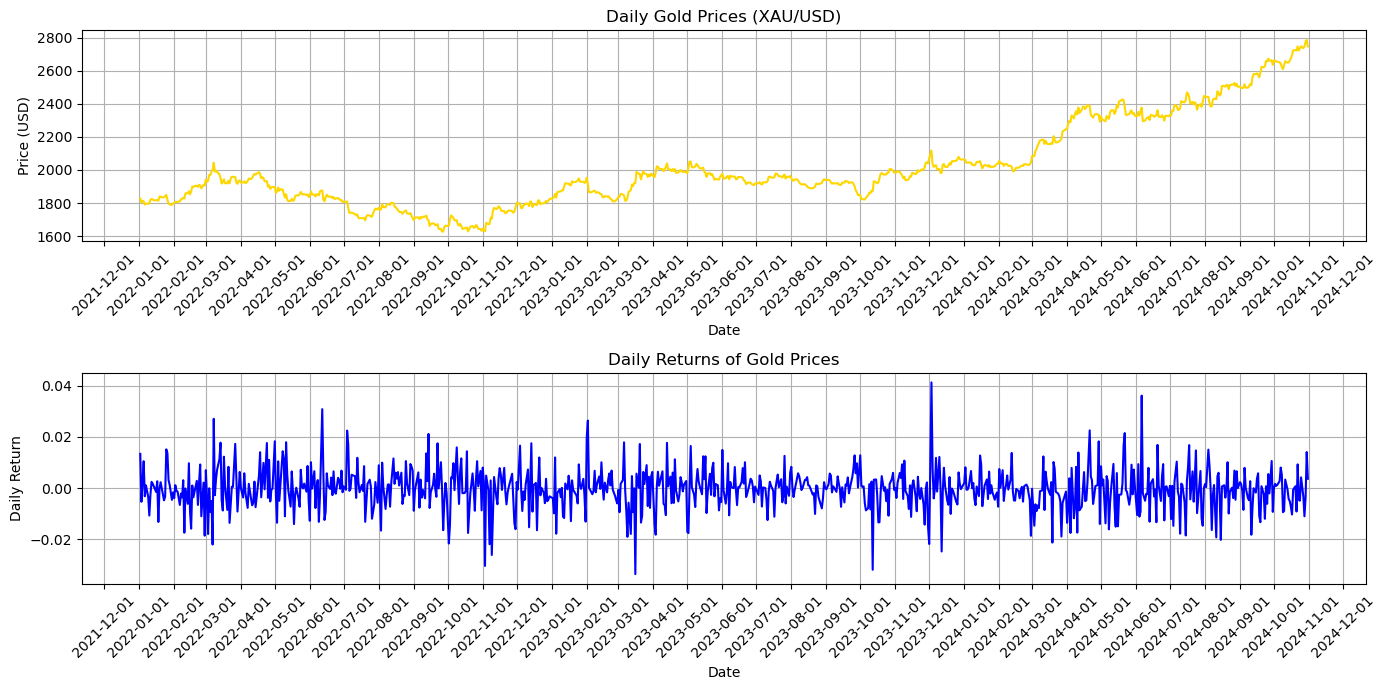

In [31]:
API_KEY = 'Z0DE340OS7NQCG0Q' 

def get_gold_price():
    """Fetches daily gold prices from Alpha Vantage API."""
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=XAUUSD&apikey={API_KEY}&outputsize=full'
    response = requests.get(url)

    if response.status_code != 200:
        print(f"Error fetching data: {response.status_code}")
        return None

    data = response.json()
    if 'Time Series (Daily)' not in data:
        print("Error: 'Time Series (Daily)' not found.")
        return None

    gold_prices = {date: float(info['4. close']) for date, info in data['Time Series (Daily)'].items()}
    return pd.DataFrame(list(gold_prices.items()), columns=['Date', 'Close']).set_index('Date')

def preprocess_gold_data(gold_data):
    """Calculates daily returns for gold prices."""
    gold_data.index = pd.to_datetime(gold_data.index)
    gold_data['Return'] = gold_data['Close'].pct_change()
    return gold_data.sort_index()

def visualize_gold_data(gold_data):
    """Visualizes gold prices and daily returns."""
    fig, axs = plt.subplots(2, 1, figsize=(14, 7))

    axs[0].plot(gold_data['Date'], gold_data['gold_spot_Close'], color='gold')
    axs[0].set_title('Daily Gold Prices (XAU/USD)')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Price (USD)')
    axs[0].grid()

    axs[1].plot(gold_data['Date'], gold_data['gold_spot_Daily_Return'], color='blue')
    axs[1].set_title('Daily Returns of Gold Prices')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('Daily Return')
    axs[1].grid()

    for ax in axs:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

    plt.tight_layout()
    plt.show()

# Main execution
gold_data = get_gold_price()
if gold_data is not None:
    processed_gold_data = preprocess_gold_data(gold_data)
    filtered_gold_data = processed_gold_data.loc['2022-01-01':'2024-10-31'].reset_index()
    filtered_gold_data.columns = ['Date', 'gold_spot_Close', 'gold_spot_Daily_Return']

    # Merge with df
    df = pd.merge(df, filtered_gold_data, on='Date', how='left')

    # Visualize data
    visualize_gold_data(filtered_gold_data)


# USD/KRW 데이터 수집

[*********************100%***********************]  1 of 1 completed


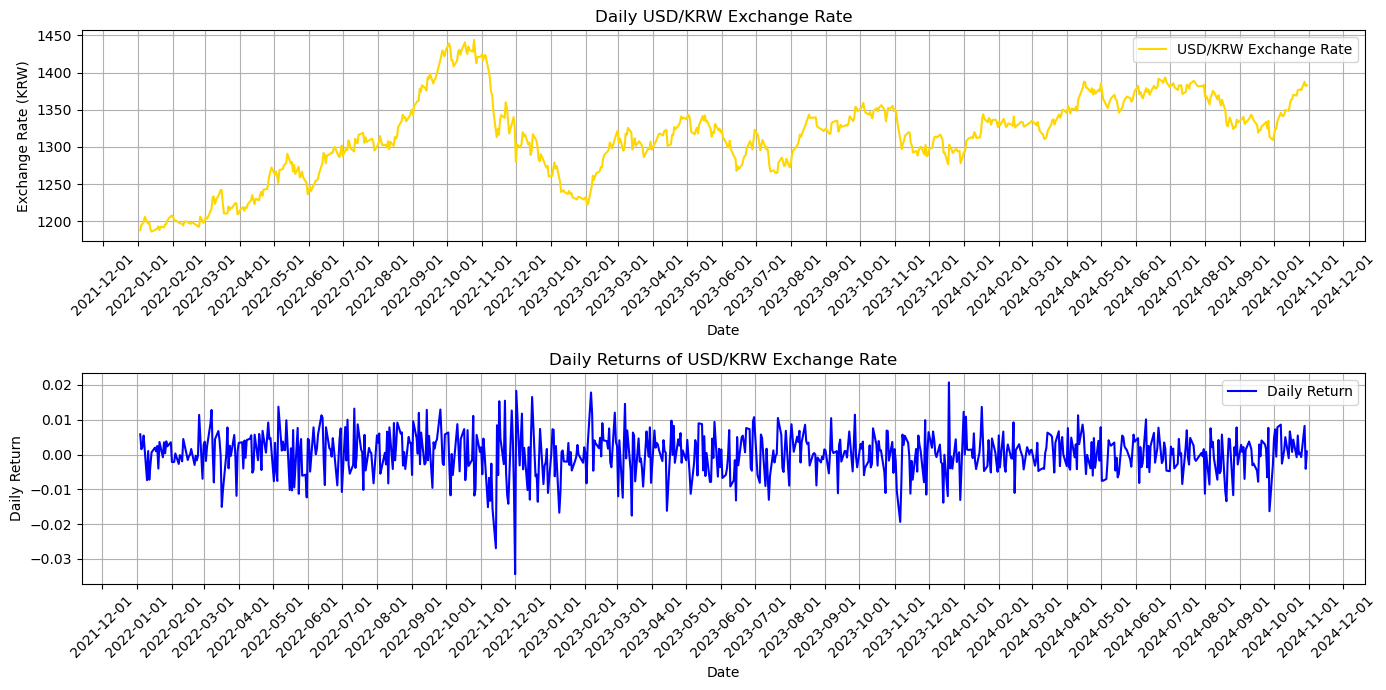

In [36]:
def fetch_usd_to_krw(start_date, end_date):
    """Fetches USD/KRW exchange rate data from Yahoo Finance."""
    try:
        data = yf.download('KRW=X', start=start_date, end=end_date)
        data['Return'] = data['Adj Close'].pct_change()
        data['Date'] = data.index
        data.reset_index(drop=True, inplace=True)
        data['Date'] = data['Date'].dt.tz_localize(None)
        
        data = data[['Date', 'Adj Close', 'Return']]
        data.columns = ['Date', 'Dollar_Won_Exchange_Rate_Close', 'Dollar_Won_Exchange_Rate_Daily_Return']
        return data
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

def plot_exchange_rate(data):
    """Plots the USD/KRW exchange rate and its daily returns."""
    plt.figure(figsize=(14, 7))

    plt.subplot(2, 1, 1)
    plt.plot(data['Date'], data['Dollar_Won_Exchange_Rate_Close'], label='USD/KRW Exchange Rate', color='gold')
    plt.title('Daily USD/KRW Exchange Rate')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate (KRW)')
    plt.grid()
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(data['Date'], data['Dollar_Won_Exchange_Rate_Daily_Return'], label='Daily Return', color='blue')
    plt.title('Daily Returns of USD/KRW Exchange Rate')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.grid()
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.legend()

    plt.tight_layout()
    plt.show()

# Main execution
usd_to_krw_data = fetch_usd_to_krw('2022-01-01', '2024-10-31')
if usd_to_krw_data is not None:
    df = pd.merge(df, usd_to_krw_data, on='Date', how='left')
    plot_exchange_rate(usd_to_krw_data)


# 한미 기준 금리 데이터 수집

C:\Users\Administrator\AppData\Local\Temp\ipykernel_25452\1628878416.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.rename(columns={


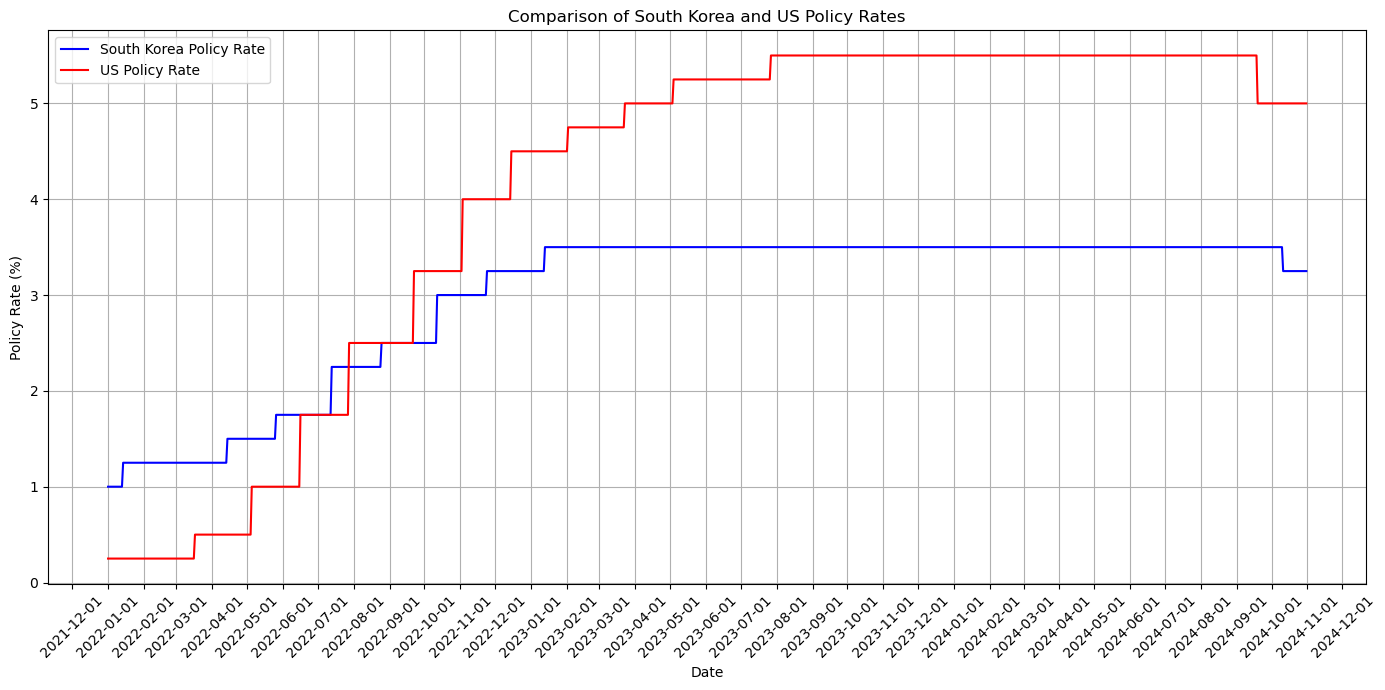

In [38]:
def load_interest_rate_data(file_path, start_date='2022-01-01', end_date='2024-10-31'):
    """Load interest rate data from a CSV file and filter by date range."""
    try:
        interest_rate = pd.read_csv(file_path)
        interest_rate['기간'] = pd.to_datetime(interest_rate['기간'])
        filtered_data = interest_rate[(interest_rate['기간'] >= start_date) & (interest_rate['기간'] <= end_date)]
        filtered_data.rename(columns={
            '기간': 'Date',
            '한국 정책금리': 'Korea_Policy_Rate',
            '미국 정책금리': 'US_Policy_Rate'
        }, inplace=True)
        return filtered_data[['Date', 'Korea_Policy_Rate', 'US_Policy_Rate']]
    except (FileNotFoundError, pd.errors.EmptyDataError) as e:
        print(f"Error loading data: {e}")
        return None

def plot_interest_rates(data):
    """Plot the comparison of South Korea and US policy rates."""
    plt.figure(figsize=(14, 7))
    plt.plot(data['Date'], data['Korea_Policy_Rate'], label='South Korea Policy Rate', color='blue')
    plt.plot(data['Date'], data['US_Policy_Rate'], label='US Policy Rate', color='red')
    plt.title('Comparison of South Korea and US Policy Rates')
    plt.xlabel('Date')
    plt.ylabel('Policy Rate (%)')
    plt.grid()
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.legend()
    plt.tight_layout()
    plt.show()

# Main execution
file_inter = '한미 정책금리.csv'
filtered_interest_rate_data = load_interest_rate_data(file_inter)

if filtered_interest_rate_data is not None:
    df = pd.merge(df, filtered_interest_rate_data, on='Date', how='left')
    plot_interest_rates(filtered_interest_rate_data)


# 소비자 물가 지수(CPI) 데이터 수집
CPI: 미국 노동부 산하 노동통계국에서 발표하는 물가에 대한 경제 지표
- 대중적인 물가 지표로 금융 상품과 연동되어 널리 활용
- 월별 데이터이며, 업데이트 속도가 다른 데이터에 비해 2달 정도 느림
=> 선형 보간을 활용하여 2달치 데이터를 예측하고 일별 데이터 채움

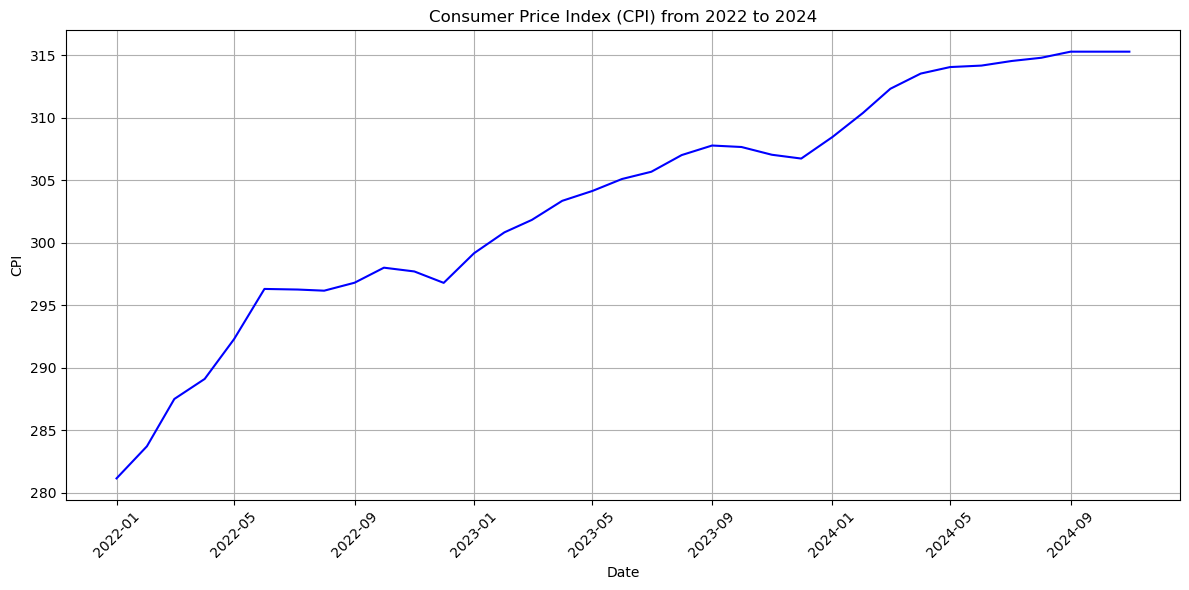

In [80]:
api_key = '350f215fbdc3b91ea0e97f23c9d1ed77'

def get_inflation_data(api_key):
    """Fetch CPI data from the FRED API."""
    url = f'https://api.stlouisfed.org/fred/series/observations?series_id=CPIAUCNS&api_key={api_key}&file_type=json'
    try:
        response = requests.get(url)
        response.raise_for_status()  # Check for HTTP errors
        data = pd.DataFrame(response.json()['observations'])
        data['Date'] = pd.to_datetime(data['date'])
        data['CPI'] = pd.to_numeric(data['value'], errors='coerce')
        return data[['Date', 'CPI']][(data['Date'] >= '2022-01-01') & (data['Date'] <= '2024-09-01')]
    except requests.RequestException as e:
        print(f"Error fetching data: {e}")
        return pd.DataFrame(columns=['Date', 'CPI'])

def fill_daily_cpi(cpi_data):
    """Fill daily CPI data using linear interpolation."""
    cpi_data.set_index('Date', inplace=True)
    daily_cpi = cpi_data.resample('D').interpolate(method='linear')
    extended_dates = pd.date_range(start='2024-10-01', end='2024-10-31', freq='D')
    daily_cpi = pd.concat([daily_cpi, pd.DataFrame(index=extended_dates)]).interpolate(method='linear')
    daily_cpi.reset_index(inplace=True)  # 인덱스를 초기화하여 'Date' 열로 변경
    daily_cpi.rename(columns={'index': 'Date'}, inplace=True)  # 'index'를 'Date'로 변경
    return daily_cpi

def plot_cpi_data(daily_cpi):
    """Plot the CPI data."""
    plt.figure(figsize=(12, 6))
    plt.plot(daily_cpi['Date'], daily_cpi['CPI'], color='blue')
    plt.title('Consumer Price Index (CPI) from 2022 to 2024')
    plt.xlabel('Date')
    plt.ylabel('CPI')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    cpi_data = get_inflation_data(api_key)
    if not cpi_data.empty:
        daily_cpi = fill_daily_cpi(cpi_data)
        df = pd.merge(df, daily_cpi, on='Date', how='left')
        plot_cpi_data(daily_cpi)
    else:
        print("No data available to plot.")


# 세계 불확실성 지수(WUI) 데이터 수집
WUI: 전 세계의 전반적인 불확실성을 측정, 71개국의 GDP을 기반으로 가중치를 두어 계산

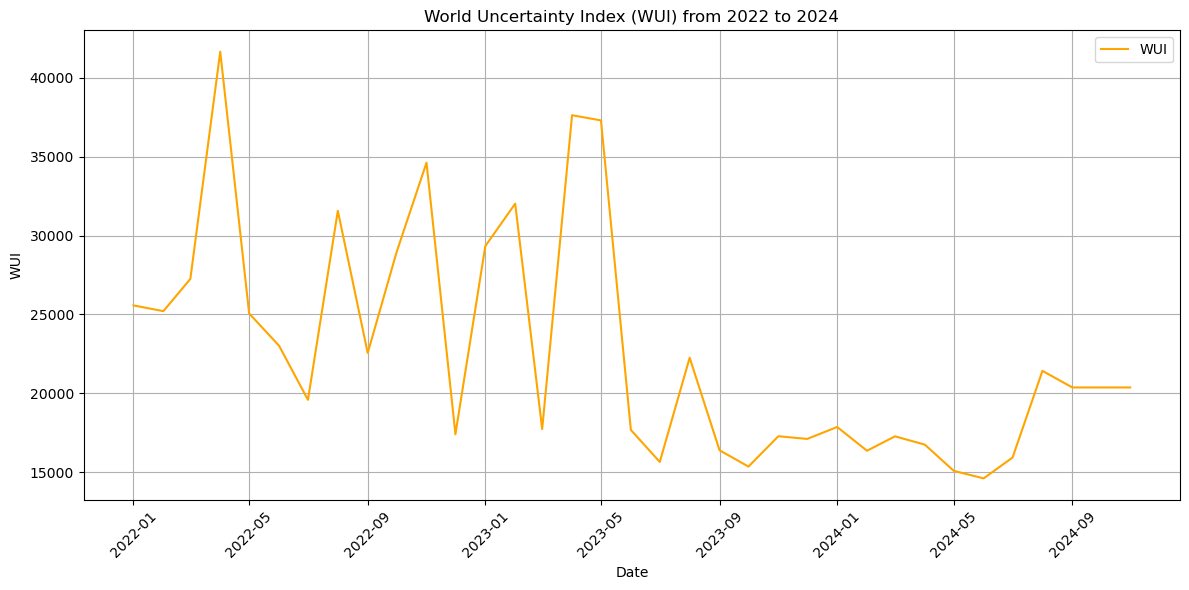

In [83]:
def get_wui_data(file_path):
    """Load WUI data from a CSV file, returning filtered DataFrame."""
    wui_data = pd.read_csv(file_path)
    wui_data['Date'] = pd.to_datetime(wui_data['Date'], errors='coerce')
    wui_data['WUI'] = wui_data['WUI'].str.replace(',', '').astype(float)
    
    if wui_data['WUI'].isna().any():
        raise ValueError("WUI column contains NaN values after conversion.")
    
    return wui_data[(wui_data['Date'] >= '2022-01-01') & (wui_data['Date'] <= '2024-09-01')][['Date', 'WUI']]

def fill_daily_wui(wui_data):
    """Fill daily WUI data using linear interpolation."""
    daily_wui = wui_data.set_index('Date').resample('D').interpolate(method='linear')
    extended_dates = pd.date_range(start='2024-10-01', end='2024-10-31', freq='D')
    return pd.concat([daily_wui, pd.DataFrame(index=extended_dates)]).interpolate(method='linear').reset_index().rename(columns={'index': 'Date'})

def plot_wui_data(daily_wui):
    """Plot the WUI data."""
    plt.figure(figsize=(12, 6))
    plt.plot(daily_wui['Date'], daily_wui['WUI'], color='orange', label='WUI')
    plt.title('World Uncertainty Index (WUI) from 2022 to 2024')
    plt.xlabel('Date')
    plt.ylabel('WUI')
    plt.xticks(rotation=45)
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    try:
        file_path = 'WUI_data.csv'
        wui_data = get_wui_data(file_path)
        if not wui_data.empty:
            daily_wui = fill_daily_wui(wui_data)
            plot_wui_data(daily_wui)
            df = pd.merge(df, daily_wui, on='Date', how='left')
        else:
            print("No WUI data available to plot.")
    except Exception as e:
        print(f"An error occurred: {e}")


# 금, 은 선물 가격

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


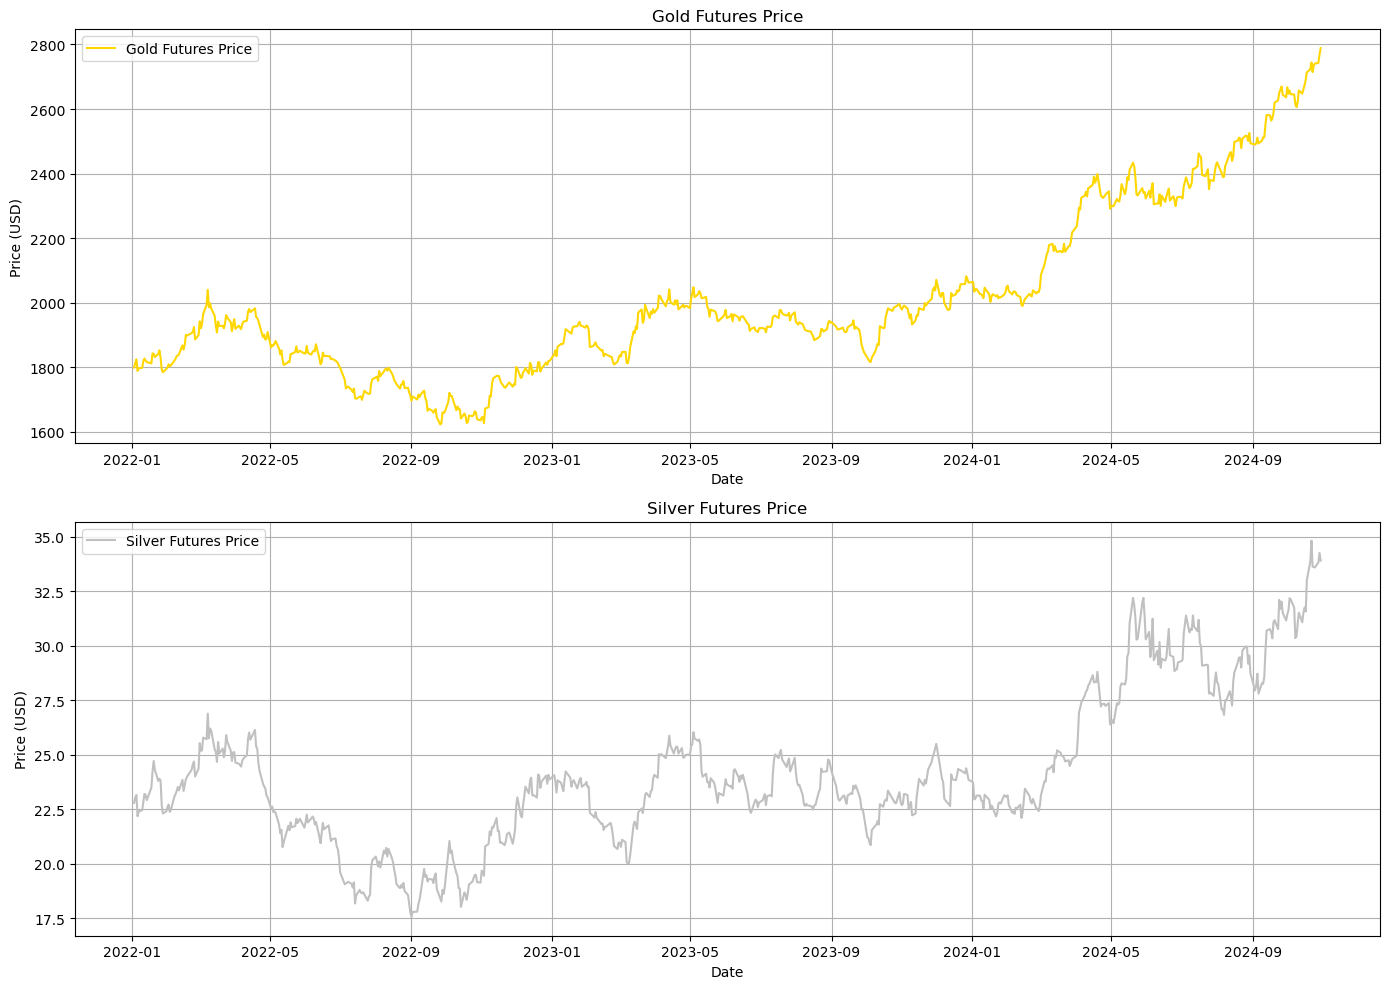

In [156]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

def get_gold_futures_price(start_date, end_date):
    # 금 선물 가격 데이터 다운로드
    gold_data = yf.download("GC=F", start=start_date, end=end_date)  # GC=F는 금 선물 가격
    gold_data.reset_index(inplace=True)
    
    # 필요한 열만 선택
    gold_data = gold_data[['Date', 'Close']]
    gold_data.columns = ['Date', 'Gold_Futures_Price']  # 열 이름 변경
    
    return gold_data

def get_silver_price(start_date, end_date):
    # 은 선물 가격 데이터 다운로드
    silver_data = yf.download("SI=F", start=start_date, end=end_date)  # SI=F는 은 선물
    silver_data.reset_index(inplace=True)
    
    # 필요한 열만 선택
    silver_data = silver_data[['Date', 'Close']]
    silver_data.columns = ['Date', 'Silver_Price']  # 열 이름 변경
    
    return silver_data

if __name__ == "__main__":
    start_date = "2022-01-01"
    end_date = "2024-10-31"
    
    # 금과 은 가격 데이터 수집
    gold_futures_price_data = get_gold_futures_price(start_date, end_date)
    silver_price_data = get_silver_price(start_date, end_date)
    
    # 데이터 병합
    combined_data = pd.merge(gold_futures_price_data, silver_price_data, on='Date', how='inner')
    
    # 그래프 그리기
    plt.figure(figsize=(14, 10))

    # 금 가격 그래프
    plt.subplot(2, 1, 1)  # 2행 1열의 첫 번째 서브플롯
    plt.plot(combined_data['Date'], combined_data['Gold_Futures_Price'], label='Gold Futures Price', color='gold')
    plt.title('Gold Futures Price')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid()

    # 은 가격 그래프
    plt.subplot(2, 1, 2)  # 2행 1열의 두 번째 서브플롯
    plt.plot(combined_data['Date'], combined_data['Silver_Price'], label='Silver Futures Price', color='silver')
    plt.title('Silver Futures Price')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid()

    plt.tight_layout()  # 레이아웃 조정
    plt.show()

In [158]:
combined_data['Date'] = combined_data['Date'].dt.tz_localize(None)
df6 = pd.merge(df5, combined_data, on='Date', how='left')

print(df6.info(), df6.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 694 entries, 0 to 693
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   Date                                   694 non-null    datetime64[ns]
 1   etf_Volume                             694 non-null    int64         
 2   etf_Daily_Return                       693 non-null    float64       
 3   gold_spot_Close                        690 non-null    float64       
 4   gold_spot_Daily_Return                 690 non-null    float64       
 5   Dollar_Won_Exchange_Rate_Close         693 non-null    float64       
 6   Dollar_Won_Exchange_Rate_Daily_Return  692 non-null    float64       
 7   Korea_Policy_Rate                      694 non-null    float64       
 8   US_Policy_Rate                         694 non-null    float64       
 9   CPI                                    656 non-null    float64   

In [139]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# 예시 데이터프레임 생성 (실제 df3를 사용해야 함)
# df3 = pd.read_csv('path_to_your_data.csv')  # 실제 데이터 로드

# 결측치 처리
df3 = df3.fillna(method='ffill')  # 결측치를 이전 값으로 채우기

# 1개월 보유 수익률 계산
# etf_Daily_Return을 30일 동안의 누적 수익률로 변환
df3['etf_1M_Return'] = (1 + df3['etf_Daily_Return']).rolling(window=30).apply(np.prod, raw=True) - 1

# 4분위수 레이블 생성
df3['Return_Quartile'] = pd.qcut(df3['etf_1M_Return'], 4, labels=[0, 1, 2, 3])  # 0~3 레이블

# 예측에 사용할 독립 변수 선택
features = df3[['etf_Volume', 'gold_spot_Close', 
                 'Dollar_Won_Exchange_Rate_Close', 
                 'Korea_Policy_Rate', 'US_Policy_Rate']]

# 종속 변수
target = df3['Return_Quartile'].shift(-30)  # 다음 30일의 수익률을 예측하기 위해 시프트

# 결측치 제거
features = features[:-30]  # 예측할 수 없는 마지막 30일 제거
target = target[:-30]

# 훈련 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# 모델 훈련 - 로지스틱 회귀 사용
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 성능 평가
print(classification_report(y_test, y_pred))

# 예측 결과 출력
predicted_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(predicted_df)



              precision    recall  f1-score   support

           0       0.26      0.19      0.22        31
           1       0.37      0.51      0.43        39
           2       0.00      0.00      0.00        33
           3       0.33      0.53      0.41        30

    accuracy                           0.32       133
   macro avg       0.24      0.31      0.26       133
weighted avg       0.24      0.32      0.27       133

    Actual  Predicted
281      3          1
286      3          1
473      0          3
227      1          1
436      2          0
..     ...        ...
628      1          3
534      3          3
443      2          0
257      1          3
210      0          1

[133 rows x 2 columns]


C:\Users\Administrator\AppData\Local\Temp\ipykernel_27500\1651150232.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df3 = df3.fillna(method='ffill')  # 결측치를 이전 값으로 채우기


In [163]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from tensorflow import keras
from tensorflow.keras import layers

# df6 데이터프레임 생성 (실제 데이터 로드)
# df6 = pd.read_csv('path_to_your_data.csv')  # 실제 데이터 로드

# 결측치 처리
df6 = df6.ffill()  # 결측치를 이전 값으로 채우기

# 1개월 보유 수익률 계산
df6['etf_1M_Return'] = (1 + df6['etf_Daily_Return']).rolling(window=30).apply(np.prod, raw=True) - 1

# 4분위수 레이블 생성
df6['Return_Quartile'] = pd.qcut(df6['etf_1M_Return'], 4, labels=[0, 1, 2, 3])  # 0~3 레이블

# NaN 처리: Return_Quartile이 NaN인 행 제거
df6 = df6.dropna(subset=['Return_Quartile'])

# 정수형으로 변환
df6['Return_Quartile'] = df6['Return_Quartile'].astype(int)

# 예측에 사용할 독립 변수 선택
features = df6[['etf_Volume', 
                 'gold_spot_Close', 
                 'Dollar_Won_Exchange_Rate_Close', 
                 'Korea_Policy_Rate', 
                 'US_Policy_Rate', 
                 'CPI', 
                 'VIX', 
                 'Gold_Futures_Price', 
                 'Silver_Price']]

# 종속 변수
target = df6['Return_Quartile'].shift(-30)  # 다음 30일의 수익률을 예측하기 위해 시프트

# 결측치 제거
features = features[:-30]  # 예측할 수 없는 마지막 30일 제거
target = target[:-30]

# 훈련 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 딥러닝 모델 구축
model = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),  # 정확한 입력 형식 지정
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(4, activation='softmax')  # 4분위수 예측을 위한 출력층
])

# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2)

# 예측
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)  # 확률을 클래스 레이블로 변환

# 성능 평가
print(classification_report(y_test, y_pred_classes))

# 예측 결과 출력
predicted_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_classes})
print(predicted_df)


Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.2639 - loss: 1.3957 - val_accuracy: 0.3039 - val_loss: 1.3403
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4506 - loss: 1.3018 - val_accuracy: 0.4020 - val_loss: 1.2859
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4344 - loss: 1.2739 - val_accuracy: 0.4020 - val_loss: 1.2550
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4249 - loss: 1.2491 - val_accuracy: 0.4216 - val_loss: 1.2327
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4533 - loss: 1.2126 - val_accuracy: 0.4020 - val_loss: 1.2189
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5012 - loss: 1.2059 - val_accuracy: 0.4216 - val_loss: 1.1970
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4568 - loss: 1.1805 - val_accuracy: 0.4510 - val_loss: 1.1840
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4775 - loss: 1.1851 - val_accuracy: 0.4706 - 